In [1]:
import os
import numpy as np
import pandas as pd
from datetime import datetime,timedelta
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
import collections
import shap
import pandas.core.algorithms as algos
from pandas import Series
import scipy.stats.stats as stats
import traceback
import re
import string
import warnings
from datetime import datetime
import time


import cv2
import pydicom as dicom
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import mean_squared_error, r2_score

from pydicom import dcmread
from skimage import data, color

from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator

from skimage import morphology
import random

calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.


In [2]:
# Import the otsu threshold function
from skimage.filters import threshold_otsu

# Import Gaussian filter
from skimage.filters import gaussian


#read image file
def dicom_to_array(filename):
    d = dicom.read_file(filename)
    a = d.pixel_array
    return a,d


#Display one image
def show_image(image, title='Image', cmap_type='gray'):
    plt.imshow(image, cmap=cmap_type)
    plt.title(title)
    plt.axis('off')
    plt.show()

#Display two images    
def plot_comparison(original, filtered, title_filtered):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 6), sharex=True,
    sharey=True)
    ax1.imshow(original, cmap=plt.cm.gray)
    ax1.set_title('original')
    ax1.axis('off')
    ax2.imshow(filtered, cmap=plt.cm.gray)
    ax2.set_title(title_filtered)
    ax2.axis('off')

    
#Image scaling   
def imgResize(a1):
    width= a1.shape[1]
    height = a1.shape[0]
    ratio = width / height
    new_height = 32

    #new_width = int(ratio * new_height)

    #new_width = int(ratio * new_height)
    new_width=32
    dim=(new_width,new_height)

    #resized_img = resize(a1, dim, anti_aliasing=True)
    resized_img = cv2.resize(a1, dim, interpolation = cv2.INTER_AREA)

    return resized_img

#Gray scale image
def imgGray(a1):
    grayscale=color.rgb2gray(a1)  
    return grayscale



# Removing noise with gaussian filter
def smoothing(a1):
    # Apply filter
    gaussian_image = gaussian(a1, multichannel=True)
    
    return gaussian_image
    # Show original and resulting image to compare
    #plot_comparison(original, gaussian_image, "Blurred with Gaussian filter")
    #show_image(original, "Original")
    #show_image(gaussian_image, "Reduced sharpness Gaussian")


#Thresholding
def thresh_otsu(a1):
    # Obtain the optimal threshold value
    thresh = threshold_otsu(a1)
    # Apply thresholding to the image
    binary_global = (a1 > thresh)
    return binary_global

from skimage.transform import rotate
# Rotate the image 90 degrees clockwise


def vertical_flip(image):
    vertically_flipped = np.flipud(image)
    return vertically_flipped

def horizontal_flip(image):
    horizontally_flipped = np.fliplr(image)
    return horizontally_flipped


def rotate_image(image):
    for i in range(90,271,90):  
        print(i)
        image_rotate = rotate(image, i)
        show_image(image_rotate)
        #return image_rotated

In [3]:
import os
df = pd.read_csv('train.csv')
df_count = pd.read_csv('Melanoma_patient_info.csv')
df_melanoma_patient=pd.read_csv('Selected_melanoma_patient_info.csv')
df_nonmelanoma_patient=pd.read_csv('Selected_nonmelanoma_patient_info.csv')



In [4]:
import os
os.chdir('/Volumes/RAJ_256/Melanoma1')

df_dilated=pd.read_csv("Dilated_image.csv")
df_rotated=pd.read_csv("Rotated_image.csv")
df_shifted=pd.read_csv("Shifted_image.csv")
df_standard=pd.read_csv("Standard_image.csv")

Dilated_image_array=np.load("Dilated_image_array.npy")  #Dilated array

Rotated_image_array=np.load("Rotated_image_array.npy")  #Rotated array
Shifted_image_array=np.load("Shifted_image_array.npy")  #Shifted_array
Standard_image_array=np.load("Standard_image_array.npy")  #Standard array





In [5]:
print(Dilated_image_array.shape)
print(Rotated_image_array.shape)
print(Shifted_image_array.shape)
print(Standard_image_array.shape)

(33126, 32, 32)
(165630, 32, 32)
(165630, 32, 32, 1)
(33126, 32, 32, 1)


In [6]:
Dilated_image_array = Dilated_image_array.reshape(Dilated_image_array.shape[0], 32, 32, 1)
Rotated_image_array = Rotated_image_array.reshape(Rotated_image_array.shape[0], 32, 32, 1)


print(Dilated_image_array.shape)
print(Rotated_image_array.shape)
print(Shifted_image_array.shape)
print(Standard_image_array.shape)

(33126, 32, 32, 1)
(165630, 32, 32, 1)
(165630, 32, 32, 1)
(33126, 32, 32, 1)


In [7]:
df_dilated.head()

,image_name,image_label,index
0,ISIC_2637011.dcm,benign,0
1,ISIC_0015719.dcm,benign,1
2,ISIC_0052212.dcm,benign,2
3,ISIC_0068279.dcm,benign,3
4,ISIC_0074268.dcm,benign,4


Sanity check by directly reading image file and stored data array


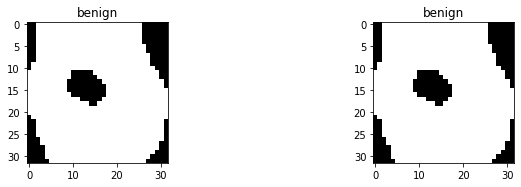

In [8]:
s=32000
print("Sanity check by directly reading image file and stored data array")

from skimage import morphology

fig = plt.figure(figsize=(15, 15))
columns = 5
rows = 5

# ax enables access to manipulate each of subplots
ax = []

for i in range(1):
    image ='train/'+df['image_name'].iloc[s] +'.dcm'
    
    a1,d = dicom_to_array(image)
      # create subplot and append to ax
     
    resized_img=imgResize(a1)
    
    #Image rescaling
    resized_img=imgResize(a1)
    
    # Removing noise with gaussian filter
    gaussian_image=smoothing(resized_img)
    
    #Gray scale image
    grayscale=imgGray(gaussian_image)
    
    # Obtain threshold image with  otsu
    binary_global=thresh_otsu(grayscale)

    # Obtain dilated image, using binary dilation
    eroded_image = morphology.binary_erosion(binary_global)
 

    # Obtain dilated image, using binary dilation
    dilated_image = morphology.binary_dilation(eroded_image)

    
    ax.append( fig.add_subplot(rows, columns, i+1) )
    # Hide grid lines
    ax[-1].grid(False)

    # Hide axes ticks
    #ax[-1].set_xticks([])
    #ax[-1].set_yticks([])
    ax[-1].set_title(df['benign_malignant'].iloc[i])

    
    
    #plt.imshow(resized_img)
    plt.imshow(dilated_image,cmap="gray")
    
    #show_image(binary_global, 'Global thresholding')


#comparision of sanity check by directly reading image file and stored data array
ax.append( fig.add_subplot(rows, columns, 3) )
plt.imshow(Dilated_image_array[s],cmap='gray')
ax[-1].set_title(df_dilated['image_label'].iloc[s])


plt.show()

In [9]:
df_rotated.head(6)

,image_name,image_label,image_title,index
0,ISIC_2637011.dcm,benign,benign_vertical,0
1,ISIC_2637011.dcm,benign,benign_horizontal,0
2,ISIC_2637011.dcm,benign,benign_90,0
3,ISIC_2637011.dcm,benign,benign_180,0
4,ISIC_2637011.dcm,benign,benign_270,0
5,ISIC_0015719.dcm,benign,benign_vertical,1


In [10]:
df_shifted.head(6)

,image_name,image_label,image_title,index
0,ISIC_2637011.dcm,benign,benign_shifted,0
1,ISIC_2637011.dcm,benign,benign_shifted,0
2,ISIC_2637011.dcm,benign,benign_shifted,0
3,ISIC_2637011.dcm,benign,benign_shifted,0
4,ISIC_2637011.dcm,benign,benign_shifted,0
5,ISIC_0015719.dcm,benign,benign_shifted,1


In [11]:
df_standard.head(6)

,image_name,image_label,image_title,index
0,ISIC_2637011.dcm,benign,benign_standardized,0
1,ISIC_0015719.dcm,benign,benign_standardized,1
2,ISIC_0052212.dcm,benign,benign_standardized,2
3,ISIC_0068279.dcm,benign,benign_standardized,3
4,ISIC_0074268.dcm,benign,benign_standardized,4
5,ISIC_0074311.dcm,benign,benign_standardized,5


In [12]:
X_index=df_melanoma_patient.df_index

(X_train_id, X_test_id)=train_test_split(X_index,test_size=0.2,random_state=42)
(X_valid_id, X_testf_id)=train_test_split(X_test_id,test_size=0.5,random_state=42)


X_train=[]
y_train=[]

for i in X_train_id:
    X_train.append(Dilated_image_array[i].astype('float32'))
    y_train.append(df_dilated.image_label[i])
    
    X_train.append(Standard_image_array[i])
    y_train.append(df_standard.image_label[i])
    
    for s in range(5):
        X_train.append(Rotated_image_array[5*i+s])
        y_train.append(df_rotated.image_label[5*i+s])
        
        X_train.append(Shifted_image_array[5*i+s])
        y_train.append(df_shifted.image_label[5*i+s])
    

In [13]:
X_index=df_melanoma_patient.df_index

(X_train_id, X_test_id)=train_test_split(X_index,test_size=0.2,random_state=42)
(X_valid_id, X_testf_id)=train_test_split(X_test_id,test_size=0.5,random_state=42)


X_train=[]
y_train=[]

for i in X_train_id:
    X_train.append(Dilated_image_array[i].astype('float32'))
    y_train.append(df_dilated.image_label[i])
    
    X_train.append(Standard_image_array[i])
    y_train.append(df_standard.image_label[i])
    
    for s in range(5):
        X_train.append(Rotated_image_array[5*i+s])
        y_train.append(df_rotated.image_label[5*i+s])
        
        X_train.append(Shifted_image_array[5*i+s])
        y_train.append(df_shifted.image_label[5*i+s])
    
   
X_valid=[]
y_valid=[]

for i in X_valid_id:
    X_valid.append(Dilated_image_array[i].astype('float32'))
    y_valid.append(df_dilated.image_label[i])
    
    X_valid.append(Standard_image_array[i])
    y_valid.append(df_standard.image_label[i])
    
    for s in range(5):
        X_valid.append(Rotated_image_array[5*i+s])
        y_valid.append(df_rotated.image_label[5*i+s])
        
        X_valid.append(Shifted_image_array[5*i+s])
        y_valid.append(df_shifted.image_label[5*i+s])


X_test=[]
y_test=[]

for i in X_testf_id:
    X_test.append(Dilated_image_array[i].astype('float32'))
    y_test.append(df_dilated.image_label[i])

    
    
unique, counts = np.unique(y_train, return_counts=True)   
print(unique)


train_label=[]

for target in y_train:
    try:
        if (target==unique[0]):
            train_label.append(0) 
        elif (target==unique[1]):
            train_label.append(1)  
    except ValueError:
        print("Oops!  That was not a train target.")

        
validation_label=[]

for target in y_valid:
    try:
        if (target==unique[0]):
            validation_label.append(0) 
        elif (target==unique[1]):
            validation_label.append(1)  
    except ValueError:
        print("Oops!  That was not a valid target.")        
        
test_label=[]

for target in y_test:
    try:
        if (target==unique[0]):
            test_label.append(0) 
        elif (target==unique[1]):
            test_label.append(1)  
    except ValueError:
        print("Oops!  That was not a test target.")        
     

X_train=np.array(X_train)
X_test=np.array(X_test)
X_valid=np.array(X_valid)


X_train_array=X_train.astype('float32')
X_test_array=X_test.astype('float32')
X_valid_array=X_valid.astype('float32')

train_inputs=X_train_array/255.0
validation_inputs=X_valid_array/255.0
test_inputs=X_test_array/255.0


print("Training_images",X_train.shape)
print("Test_images",X_test.shape)
print("Valid_images",X_valid.shape)



['benign' 'malignant']
Training_images (13680, 32, 32, 1)
Test_images (143, 32, 32, 1)
Valid_images (1716, 32, 32, 1)


In [14]:
X_train_NN = train_inputs.reshape(train_inputs.shape[0], train_inputs.shape[1]*train_inputs.shape[2])
X_test_NN =  test_inputs.reshape(test_inputs.shape[0], test_inputs.shape[1]*test_inputs.shape[2])
X_valid_NN = validation_inputs.reshape(validation_inputs.shape[0], validation_inputs.shape[1]*validation_inputs.shape[2])


train_label=np.array(train_label)
validation_label=np.array(validation_label)
test_label=np.array(test_label)

print(X_train_NN.shape,train_label.shape)
print(X_valid_NN.shape,validation_label.shape)
print(X_test_NN.shape,test_label.shape)

(13680, 1024) (13680,)
(1716, 1024) (1716,)
(143, 1024) (143,)


In [15]:
#In a two class problem, there is no difference at all between using a softmax with 
#two outputs or one binary output, assuming you use a sigmoid (logistic) function 
#to model the probability of the output. The two things are mathematically equivalent.

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.utils import Sequence
from sklearn.metrics import roc_curve
from sklearn.metrics import auc


hidden_layer_size=500
hidden_layer_size1=200
hidden_layer_size2=50

input_size = train_inputs.shape[1]*train_inputs.shape[2]
print(input_size)

def build_model():
    model = Sequential()
    model.add(Dense(hidden_layer_size, input_dim=input_size, activation='relu'))
    model.add(Dense(hidden_layer_size1, activation='relu'))
    #model.add(Dense(hidden_layer_size2, activation='relu'))
    model.add(Dense(1, activation='sigmoid')
             )
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['AUC'])
    return model

early_stopping = tf.keras.callbacks.EarlyStopping(patience=2)

from keras.wrappers.scikit_learn import KerasClassifier
keras_model = build_model()

keras_model = build_model()
history=keras_model.fit(X_train_NN, train_label, batch_size=100, epochs=100, callbacks=[early_stopping], validation_data=(X_valid_NN, validation_label), verbose=2)

keras_model.summary()
# evaluate the model
print("validatiaon loss", history.history['val_loss'][-1],"validataion AUC",history.history['val_auc'][-1])




1024
Epoch 1/100
137/137 - 17s - loss: 0.6789 - auc: 0.5450 - val_loss: 0.6581 - val_auc: 0.6407
Epoch 2/100
137/137 - 1s - loss: 0.6619 - auc: 0.6062 - val_loss: 0.6511 - val_auc: 0.6415
Epoch 3/100
137/137 - 1s - loss: 0.6529 - auc: 0.6268 - val_loss: 0.6400 - val_auc: 0.6539
Epoch 4/100
137/137 - 1s - loss: 0.6480 - auc: 0.6375 - val_loss: 0.6386 - val_auc: 0.6546
Epoch 5/100
137/137 - 1s - loss: 0.6411 - auc: 0.6493 - val_loss: 0.6439 - val_auc: 0.6517
Epoch 6/100
137/137 - 0s - loss: 0.6356 - auc: 0.6590 - val_loss: 0.6496 - val_auc: 0.6413
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 500)               512500    
_________________________________________________________________
dense_4 (Dense)              (None, 200)               100200    
_________________________________________________________________
dense_5 (Dense)              (

<Figure size 432x288 with 0 Axes>

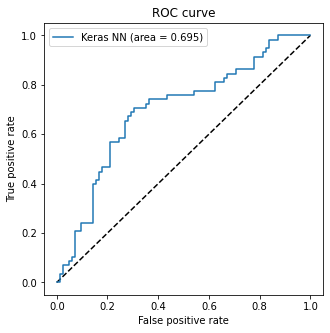

Confusion matrix without normalization
[[73 12]
 [35 23]]
 


<Figure size 432x288 with 0 Axes>

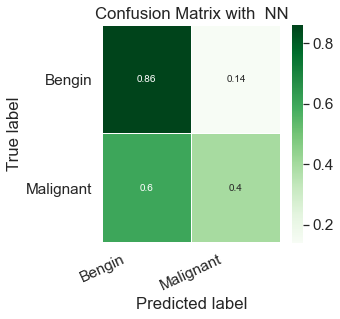

In [16]:
plt.figure(1)
fig = plt.figure(figsize=(5, 5))

# plot loss during training
#plt.subplot(111)
#plt.title('Loss')
#plt.plot(history.history['loss'], label='train loss')
#plt.plot(history.history['val_loss'], label='validation loss')
#plt.legend()
#plt.show()



y_pred_keras = keras_model.predict(X_test_NN)
fpr_keras, tpr_keras, thresholds_keras = roc_curve(test_label, y_pred_keras)

                          
auc_keras = auc(fpr_keras, tpr_keras)
auc_keras
plt.figure(2)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras NN (area = {:.3f})'.format(auc_keras))
#plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

rounded_predictions=[]
for i in range(len(y_pred_keras)):
    #print(y_pred_keras[i][0], round(y_pred_keras[i][0]))
    rounded_predictions.append(round(y_pred_keras[i][0]))

print("Confusion matrix without normalization")
print(confusion_matrix(y_true=test_label, y_pred=rounded_predictions))



#matrix = confusion_matrix(y_test, y_pred3)
matrix=confusion_matrix(y_true=test_label, y_pred=rounded_predictions)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
#print(matrix)

print(' ')

# Build the plot
plt.figure(3)

plt.figure(figsize=(4,4))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['Bengin', 'Malignant']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
#plt.title('Confusion Matrix for neural network with equalized data')
plt.title('Confusion Matrix with  NN')
plt.show()




In [17]:
import tensorflow as tf
import keras
from keras.models import Sequential
from tensorflow.keras.utils import Sequence
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from keras.utils import np_utils


X_train_cnn = train_inputs.reshape(train_inputs.shape[0], 32, 32, 1)
X_test_cnn =  test_inputs.reshape(test_inputs.shape[0], 32, 32, 1)
X_valid_cnn = validation_inputs.reshape(validation_inputs.shape[0], 32, 32, 1)

print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)


# building a linear stack of layers with the sequential model
model = Sequential()

# convolutional layer
model.add(Conv2D(32, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu', input_shape=(32, 32, 1)))

#model.add(Conv2D(32, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu', input_shape=(32, 32, 1)))
#model.add(MaxPooling2D(pool_size=(2,2))
#model.add(Conv2D(64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu', input_shape=(32, 32, 1)))
#model.add(MaxPooling2D(pool_size=(2,2))

model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# convolutional layer
model.add(Conv2D(64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(128, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# flatten output of conv
model.add(Flatten())

# hidden layer
model.add(Dense(hidden_layer_size, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(hidden_layer_size1, activation='relu'))
model.add(Dropout(0.2))
# output layer
##model.add(Dense(2, activation='softmax'))
model.add(Dense(1, activation='sigmoid'))


# compiling the sequential model

opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['AUC'])

early_stopping = tf.keras.callbacks.EarlyStopping(patience=3)
model.fit(X_train_cnn, train_label, batch_size=128, epochs=100, validation_data=(X_valid_cnn, validation_label),callbacks=[early_stopping])


model.summary()


(13680, 32, 32, 1)
(1716, 32, 32, 1)
(143, 32, 32, 1)
Epoch 1/100
107/107 [==============================] - 20s 154ms/step - loss: 0.6825 - auc: 0.4900 - val_loss: 0.6710 - val_auc: 0.5167
Epoch 2/100
107/107 [==============================] - 15s 144ms/step - loss: 0.6767 - auc: 0.5033 - val_loss: 0.6682 - val_auc: 0.5192
Epoch 3/100
107/107 [==============================] - 14s 132ms/step - loss: 0.6798 - auc: 0.5021 - val_loss: 0.6672 - val_auc: 0.5098
Epoch 4/100
107/107 [==============================] - 14s 128ms/step - loss: 0.6751 - auc: 0.5079 - val_loss: 0.6701 - val_auc: 0.5152
Epoch 5/100
107/107 [==============================] - 13s 125ms/step - loss: 0.6737 - auc: 0.5233 - val_loss: 0.6662 - val_auc: 0.6357
Epoch 6/100
107/107 [==============================] - 13s 123ms/step - loss: 0.6715 - auc: 0.5645 - val_loss: 0.6460 - val_auc: 0.6586
Epoch 7/100
107/107 [==============================] - 13s 126ms/step - loss: 0.6605 - auc: 0.6087 - val_loss: 0.6522 - val_auc: 0

In [18]:
 #evaluate the model
print("validatiaon loss", model.history.history['val_loss'][-1],"validataion AUC",model.history.history['val_auc'][-1])

#plt.figure(1)
#fig = plt.figure(figsize=(15, 15))

# plot loss during training
##plt.subplot(121)
#plt.title('Loss')
#plt.plot(model.history.history['loss'],label='train loss')
#plt.plot(model.history.history['val_loss'],label='validation loss')
#plt.legend()
#plt.show()

validatiaon loss 0.6490564346313477 validataion AUC 0.64614337682724


(143, 1)


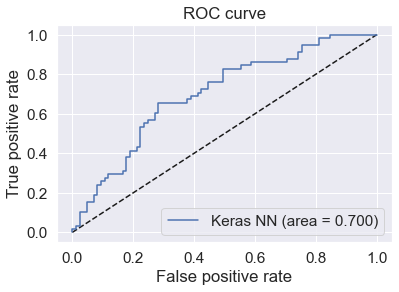

Confusion matrix without normalization
[[66 19]
 [28 30]]
 


<Figure size 432x288 with 0 Axes>

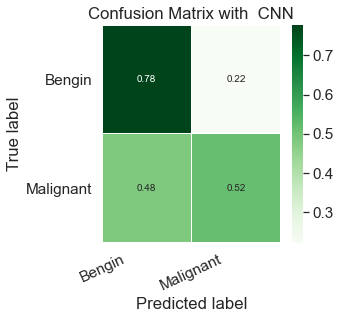

In [19]:
num_classes=2
Y_valid=test_label
y_pred_keras = model.predict(X_test_cnn) 
print(y_pred_keras.shape)

rounded_predictions=[]
for i in range(len(y_pred_keras)):
    A=[round(i) for i in y_pred_keras[i]]
    rounded_predictions.append(A)

fpr_keras, tpr_keras, thresholds_keras = roc_curve(test_label, y_pred_keras)

                          
auc_keras = auc(fpr_keras, tpr_keras)
auc_keras
plt.figure(2)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras NN (area = {:.3f})'.format(auc_keras))
#plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()


    
print("Confusion matrix without normalization")
print(confusion_matrix(y_true=test_label, y_pred=rounded_predictions))



#matrix = confusion_matrix(y_test, y_pred3)
matrix=confusion_matrix(y_true=test_label, y_pred=rounded_predictions)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
#print(matrix)

print(' ')

# Build the plot
plt.figure(3)

plt.figure(figsize=(4,4))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['Bengin', 'Malignant']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
#plt.title('Confusion Matrix for neural network with equalized data')
plt.title('Confusion Matrix with  CNN')
plt.show()


